<a href="https://colab.research.google.com/github/curtiscu/LYIT/blob/master/2020_12_11_tryingAnalytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gathering EDA for report content

## TODO - stuff I need to try..

- data looks non-parametric, prove this? tests here...
  - https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/ 
  - https://machinelearningmastery.com/how-to-transform-data-to-fit-the-normal-distribution/ 
  - https://stackoverflow.com/a/7788452 

- suitable classifiers for non-parametric data are knn, decision trees, and RBF kernel SVM, as per
  - https://sebastianraschka.com/faq/docs/parametric_vs_nonparametric.html 


more info on non/ param models that looks important to know for viva!
- https://sebastianraschka.com/faq/docs/parametric_vs_nonparametric.html 

# Setup Colab env


In [1]:

import sklearn
sklearn.__version__
!pip install --upgrade scikit-learn

#!pip uninstall scikit-learn -y
#!pip install scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.23.2)


In [2]:
# print all cell output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Google drive access

In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [4]:
# peek at data
! ls -al '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/'

# peek at modules from local  'E:\Google Drive\LYIT\Dissertation\modules'
! ls -al '/content/drive/My Drive/LYIT/Dissertation/modules/'

total 35
-rw------- 1 root root 2589 Apr 27  2020 10_soul-groove10_102_beat_4-4.mid
-rw------- 1 root root 4793 Apr 27  2020 1_funk-groove1_138_beat_4-4.mid
-rw------- 1 root root 3243 Apr 27  2020 2_funk-groove2_105_beat_4-4.mid
-rw------- 1 root root 4466 Apr 27  2020 3_soul-groove3_86_beat_4-4.mid
-rw------- 1 root root 2551 Apr 27  2020 4_soul-groove4_80_beat_4-4.mid
-rw------- 1 root root 3798 Apr 27  2020 5_funk-groove5_84_beat_4-4.mid
-rw------- 1 root root 3760 Apr 27  2020 6_hiphop-groove6_87_beat_4-4.mid
-rw------- 1 root root 1894 Apr 27  2020 7_pop-groove7_138_beat_4-4.mid
-rw------- 1 root root 2437 Apr 27  2020 8_rock-groove8_65_beat_4-4.mid
-rw------- 1 root root 3448 Apr 27  2020 9_soul-groove9_105_beat_4-4.mid
total 57
-rw------- 1 root root 33311 Dec 12 23:22 data_prep.py
-rw------- 1 root root  2904 Nov 18 21:57 pipeline_utils.py
drwx------ 2 root root  4096 May 10  2020 __pycache__
-rw------- 1 root root  7847 Aug 18 22:09 stats_n_features.py
-rw------- 1 root root 

## Auto reload module

Now using library code I've created and saved to google drive which is automatically pushed to the cloud and made available to the colab env. The autoreload stuff below should help imports to 'reimport' to load changes to the library code.

It's not the quickest/ most reliable, so if in a hurry, brute force loading of changes by restarting the runtime.

In [5]:
# tool to auto reload modules.
%load_ext autoreload

# config to auto-reload all modules, handy to make 
# writing and testing modules much easier.
%autoreload 2

## Imports and accessing lib functions

In [6]:
# install required libs
!pip install mido

     |████████████████████████████████| 61kB 6.2MB/s 


In [7]:
# regular imports
import pandas as pd
import numpy as np

# scikit-learn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  MinMaxScaler, RobustScaler, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# graphics/ charts
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# misc
from scipy import stats
from collections import namedtuple
import math
import datetime
from itertools import cycle

In [8]:
import mido  # MIDI library processing
from mido import MidiFile
from mido import Message
from mido import tempo2bpm
from mido import tick2second

In [9]:
# import my modules
import sys
sys.path.append('/content/drive/My Drive/LYIT/Dissertation/modules/')
import data_prep as dp
import pipeline_utils as pu
import stats_n_features as sf

>> LOADING custom module, when: 2020-12-13 14:27:21.508233, module name: stats_n_features
>> LOADING custom module, when: 2020-12-13 14:27:21.509414, module name: data_prep
>> LOADING custom module, when: 2020-12-13 14:27:21.965403, module name: pipeline_utils


In [74]:
# test module function calls..
dp.test_function_call('bling')
sf.test_function_call('hello')

>> LOADING custom module, when: 2020-12-13 15:21:18.705823, module name: data_prep
Test function in data_prep.py called and worked! when: 2020-12-13 15:21:18.709620,  param:bling
Test function in stats_n_features called and worked! when: 2020-12-13 15:21:18.709745,  param:hello


## Pandas display options

In [11]:
def set_pandas_display_options() -> None:
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 2000
    display.max_colwidth = 1000
    display.width = None
    # display.precision = 2  # set as needed

set_pandas_display_options()
#pd.reset_option('all')


# Load & filter data...

In [75]:
##################################
######## LOAD

my_data = dp.load_all_data()
#my_data = dp.load_all_data(filter_err_buckets=False)
all_drummer_data = my_data.copy()

BULK LOAD: drummer1, drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid, funk/groove1
FILE name: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid
    loaded file: <midi file '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid' type 0, 1 tracks, 1300 messages>
    time sig: <meta message time_signature numerator=4 denominator=4 clocks_per_click=24 notated_32nd_notes_per_beat=8 time=0>
    tempo: <meta message set_tempo tempo=434783 time=0>
    track count: 1, tracks: [<midi track 'MIDI' 1300 messages>]
    MIDI file type: 0
    > processing track: <midi track 'MIDI' 1300 messages>
    __notes pre-filter: [36. 37. 38. 40. 43. 44. 51. 52. 53. 55.]
    __applying filter: [44]
    __notes post filter: [36. 37. 38. 40. 43. 51. 52. 53. 55.]
    note_on span - first tick: 3 , last tick: 30658 
    good instruments: 5, {36.0: 'Bass Drum 1 (36)', 38.0: 'Acoustic Snare (38)', 43.

## Check loading log, make sure file setup same.

In [76]:
logs_df = dp.get_last_logs()
display(logs_df.head(3))

,file_name,style,drummer,file_type,ts_num,ts_den,tempo_us,tempo_bpm,PPQN,first_hit,last_hit,bars_in_file,quantize_level,ticks_per_beat,ticks_per_bin,ms_per_bin,err_buckets
0,drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid,funk/groove1,drummer1,0,4,4,434783,137.999876,480,3,30658,16,16.0,480.0,120,0.108696,"(24, 13)"
1,drummer1/eval_session/3_soul-groove3_86_beat_4-4.mid,soul/groove3,drummer1,0,4,4,697674,86.000052,480,0,30696,16,16.0,480.0,120,0.174419,"(8, 13)"
2,drummer1/eval_session/4_soul-groove4_80_beat_4-4.mid,soul/groove4,drummer1,0,4,4,750000,80.000000,480,0,30470,16,16.0,480.0,120,0.187500,"(0, 13)"


Check file loading logs, ensure that for each style these important attributes match across all the MIDI files...

In [77]:
filtered_logs_df = logs_df[['style', 'tempo_us', 'tempo_bpm', 'ts_num', 'ts_den', 'PPQN', 'bars_in_file', 'ticks_per_bin', 'ms_per_bin']]
#check_stats_df = filtered_logs_df.groupby('style').agg([pd.Series.mode, 'nunique'])
check_stats_df = filtered_logs_df.groupby('style').agg([pd.Series.mode])
check_stats_df.columns = check_stats_df.columns.droplevel(1)
#check_stats_df.to_csv(r'/content/drive/My Drive/check_stats_df.csv')
display(check_stats_df)


,tempo_us,tempo_bpm,ts_num,ts_den,PPQN,bars_in_file,ticks_per_bin,ms_per_bin
style,,,,,,,,
funk/groove1,434783,137.999876,4,4,480,16,120,0.108696
hiphop/groove6,689655,87.000022,4,4,480,16,120,0.172414
rock/groove8,923077,64.999995,4,4,480,16,120,0.230769
soul/groove3,697674,86.000052,4,4,480,16,120,0.174419
soul/groove4,750000,80.000000,4,4,480,16,120,0.187500


## Single file tests..

In [79]:
##################################
######## EXPLORE SINGLE FILE

# experimenting on a single file here ...
key1 = '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid'
#key2 = '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid'

test_data = all_drummer_data[key1]
df1 = test_data.tight_df.copy()
#df1 = test_data.tight_style_df.copy()
df1.head()

print('stats for: {}'.format(key1))
df1['beat_offset'].groupby(df1['note']).describe()
df1['velocity'].groupby(df1['note']).describe()
df1.describe()

note  velocity  beat_offset  bar_beat_number
bar_number bar_beat_number                                              
1          1                  hh        55            7                1
           1                kick        64           10                1
           3                kick        57          -29                3
           3                  hh        31           -2                3
           5                  hh        54          -13                5

stats for: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,126.0,-4.674603,13.097071,-41.0,-12.00,-3.5,4.0,27.0
kick,54.0,-14.777778,15.486655,-54.0,-24.75,-13.0,-4.0,10.0
snare,79.0,-9.924051,20.791253,-58.0,-21.00,-8.0,0.5,55.0


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,126.0,50.436508,9.891003,30.0,44.0,49.0,56.00,83.0
kick,54.0,60.796296,15.543463,42.0,52.0,59.5,63.75,127.0
snare,79.0,71.506329,35.822523,8.0,33.0,90.0,102.00,117.0


,velocity,beat_offset,bar_beat_number
count,259.000000,259.000000,259.000000
mean,59.023166,-8.382239,7.528958
std,23.861508,16.705284,4.585338
min,8.000000,-58.000000,1.000000
25%,44.000000,-17.000000,3.000000
50%,52.000000,-7.000000,8.000000
75%,65.500000,1.500000,11.000000
max,127.000000,55.000000,16.000000


In [85]:
# pull out notes in named bars...
display(df1.xs(1, level='bar_number')) 
display(df1.xs(2, level='bar_number')) 

,note,velocity,beat_offset,bar_beat_number
bar_beat_number,,,,
1,hh,55,7,1
1,kick,64,10,1
3,kick,57,-29,3
3,hh,31,-2,3
5,hh,54,-13,5
5,snare,93,-5,5
7,hh,42,-16,7
8,snare,33,-12,8
10,snare,33,-14,10


,note,velocity,beat_offset,bar_beat_number
bar_beat_number,,,,
1,hh,42,-7,1
1,kick,55,-5,1
3,kick,62,-10,3
3,hh,41,3,3
5,snare,94,4,5
5,hh,51,5,5
7,hh,45,7,7
8,snare,32,7,8
9,hh,43,2,9


### Peek at file_df of same file

In [80]:
# extract unfiltered file_df to examine
tmp_file_df = test_data.file_df.copy()
tmp_file_df.head()
tmp_file_df.describe()
tmp_file_df['beat_offset'].groupby(tmp_file_df['note']).describe()
#tmp_file_df['velocity'].groupby(tmp_file_df['note']).describe()

track_msg_num msg_type  delta_ticks  \
bar_number bar_beat_number note                                       
1          1               49             0:6  note_on            3   
                           51             0:7  note_on            4   
                           36             0:8  note_on            3   
           3               36            0:14  note_on           22   
                           51            0:16  note_on           17   

                                 total_ticks  total_seconds  note  velocity  \
bar_number bar_beat_number note                                               
1          1               49              3       0.002717    49        60   
                           51              7       0.006341    51        55   
                           36             10       0.009058    36        64   
           3               36            211       0.191123    36        57   
                           51            238       0.215580    51        31   

                                                                                                  raw_data  \
bar_number bar_beat_number note                                                                              
1          1               49     {'type': 'note_on', 'time': 3, 'note': 55, 'velocity': 60, 'channel': 9}   
                           51     {'type': 'note_on', 'time': 4, 'note': 51, 'velocity': 55, 'channel': 9}   
                           36     {'type': 'note_on', 'time': 3, 'note': 36, 'velocity': 64, 'channel': 9}   
           3               36    {'type': 'note_on', 'time': 22, 'note': 36, 'velocity': 57, 'channel': 9}   
                           51    {'type': 'note_on', 'time': 17, 'note': 51, 'velocity': 31, 'channel': 9}   

                                 beat_offset beat_center  file_beat_number  \
bar_number bar_beat_number note                                              
1          1               49              3           0                 0   
                           51              7           0                 0   
                           36             10           0                 0   
           3               36            -29         240                 2   
                           51             -2         240                 2   

                                 beat_offset_ms  bar_number  bar_beat_number  \
bar_number bar_beat_number note                                                
1          1               49          0.002717           1                1   
                           51          0.006341           1                1   
                           36          0.009058           1                1   
           3               36         -0.026268           1                3   
                           51         -0.001812           1                3   

                                        style  
bar_number bar_beat_number note                
1          1               49    funk/groove1  
                           51    funk/groove1  
                           36    funk/groove1  
           3               36    funk/groove1  
                           51    funk/groove1

,delta_ticks,total_ticks,total_seconds,note,velocity,beat_offset,file_beat_number,beat_offset_ms,bar_number,bar_beat_number
count,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000
mean,13.996212,15389.109848,13.939424,43.981061,59.371212,-8.617424,128.314394,-0.007806,8.609848,7.556818
std,14.769329,8818.113292,7.987429,6.914718,24.050930,16.746416,73.491287,0.015169,4.589132,4.579317
min,0.000000,3.000000,0.002717,36.000000,8.000000,-58.000000,0.000000,-0.052536,1.000000,1.000000
25%,4.000000,7893.250000,7.149689,38.000000,44.000000,-18.000000,66.000000,-0.016304,5.000000,3.000000
50%,10.000000,15378.000000,13.929360,38.000000,53.000000,-7.500000,128.000000,-0.006793,9.000000,8.000000
75%,21.000000,23034.000000,20.864149,51.000000,66.000000,1.250000,192.000000,0.001132,13.000000,11.000000
max,106.000000,30452.000000,27.583358,51.000000,127.000000,55.000000,254.000000,0.049819,16.000000,16.000000


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
36,54.0,-14.777778,15.486655,-54.0,-24.75,-13.0,-4.00,10.0
38,79.0,-9.924051,20.791253,-58.0,-21.00,-8.0,0.50,55.0
43,1.0,-21.000000,NaN,-21.0,-21.00,-21.0,-21.00,-21.0
49,4.0,-20.750000,18.264264,-37.0,-34.00,-24.5,-11.25,3.0
51,126.0,-4.674603,13.097071,-41.0,-12.00,-3.5,4.00,27.0


Take a look at all file names in the complete data set...

In [81]:
list(all_drummer_data.keys())

['/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/3_soul-groove3_86_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/4_soul-groove4_80_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/6_hiphop-groove6_87_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/8_rock-groove8_65_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/3_soul-groove3_86_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/4_soul-groove4_80_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/6_hiphop-groove6_87_beat_4-4.m

# Stats: across all data

In [82]:
master_df = all_drummer_data['master_df']

In [83]:
master_df.describe()

,velocity,beat_offset,beat_offset_ms,bar_beat_number
count,5631.000000,5631.000000,5631.000000,5631.000000
mean,68.054520,-5.153969,-0.008254,8.320902
std,33.876204,14.429171,0.019941,4.574257
min,4.000000,-60.000000,-0.096154,1.000000
25%,40.500000,-14.000000,-0.020349,5.000000
50%,62.000000,-5.000000,-0.007267,8.000000
75%,96.000000,3.000000,0.004529,12.000000
max,127.000000,59.000000,0.092188,16.000000


In [84]:
master_df.describe(include='all')

,drummer_ID,note,velocity,beat_offset,beat_offset_ms,bar_beat_number,style
count,5631,5631,5631.000000,5631.000000,5631.000000,5631.000000,5631
unique,4,3,NaN,NaN,NaN,NaN,5
top,drummer1,hh,NaN,NaN,NaN,NaN,soul/groove3
freq,1498,3235,NaN,NaN,NaN,NaN,1677
mean,NaN,NaN,68.054520,-5.153969,-0.008254,8.320902,NaN
std,NaN,NaN,33.876204,14.429171,0.019941,4.574257,NaN
min,NaN,NaN,4.000000,-60.000000,-0.096154,1.000000,NaN
25%,NaN,NaN,40.500000,-14.000000,-0.020349,5.000000,NaN
50%,NaN,NaN,62.000000,-5.000000,-0.007267,8.000000,NaN
75%,NaN,NaN,96.000000,3.000000,0.004529,12.000000,NaN


## Normality tests: beat_offset

TODO: the df has offsets in ticks still. Also convert to ms, add new col.

Check histograms...

In [22]:
plt.rcParams["figure.figsize"] = (10,8)

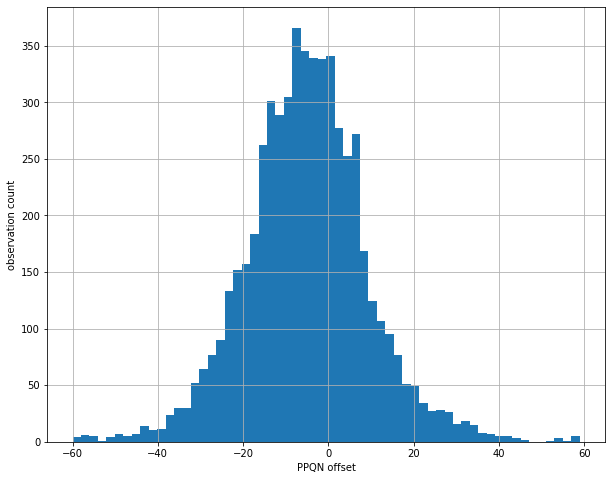

In [23]:
# check Offsets in MIDI ticks
_ = plt.ylabel('observation count')
_ = plt.xlabel('PPQN offset')
_ = master_df.beat_offset.hist(bins=60)

# WARNING - not valid, aggregates together songs recorded at diff tempos!


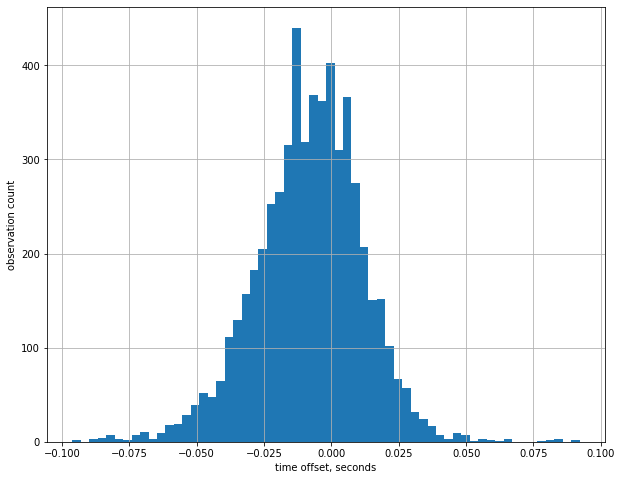

In [24]:
# WARNING - not valid, aggregates together songs that
# were recorded at different tempos.
plt.rcParams["figure.figsize"] = (10,8)
# check offsets in seconds
print('# WARNING - not valid, aggregates together songs recorded at diff tempos!')
_ = plt.ylabel('observation count')
_ = plt.xlabel('time offset, seconds')
_ = master_df.beat_offset_ms.hist(bins=60)

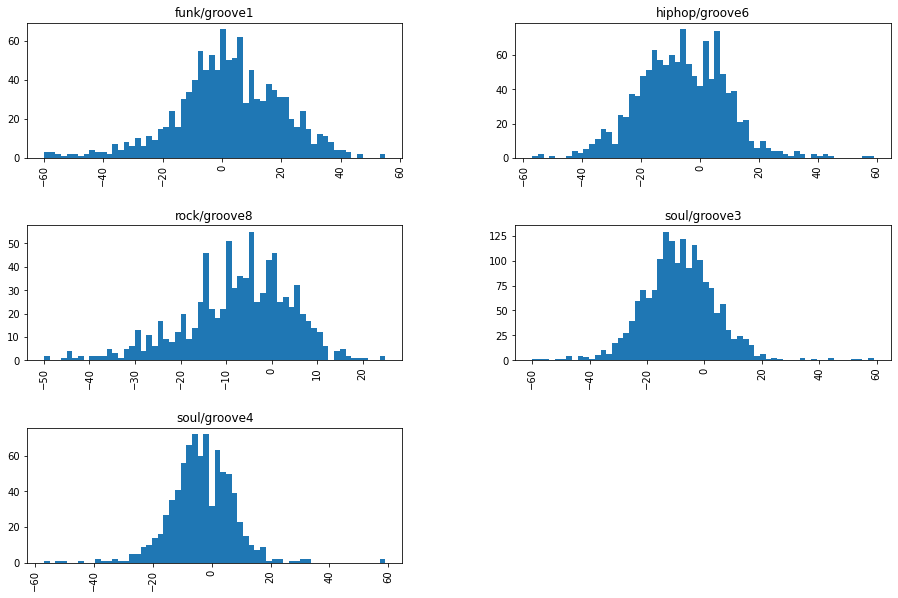

In [25]:
plt.rcParams["figure.figsize"] = (15,10)

# timing offsets in PPQN for all recorded songs, grouped by style
_ = master_df.beat_offset.hist(by=master_df['style'], bins=60)

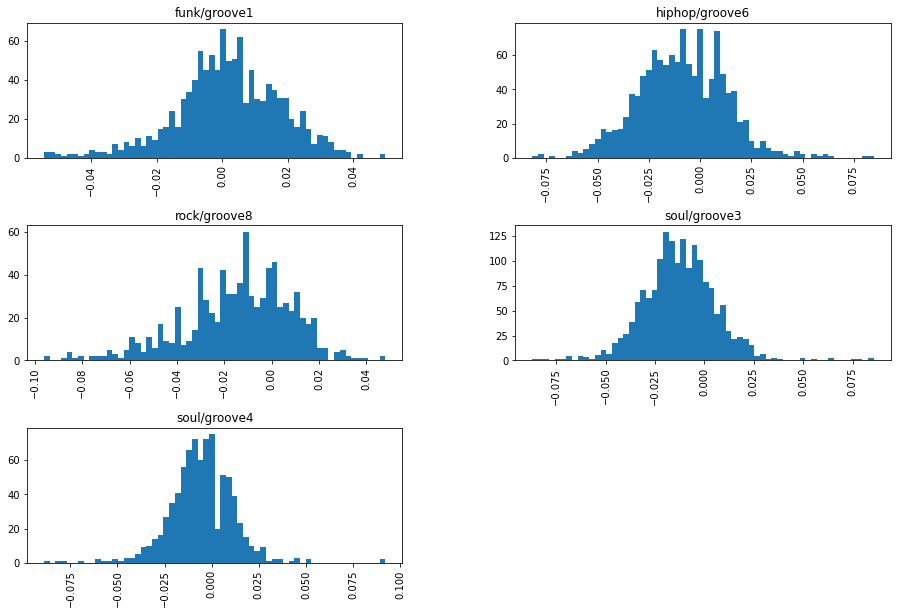

In [26]:
plt.rcParams["figure.figsize"] = (15,10)

# timing offsets in seconds for all recorded songs, grouped by style
_ = master_df.beat_offset_ms.hist(by=master_df['style'], bins=60)


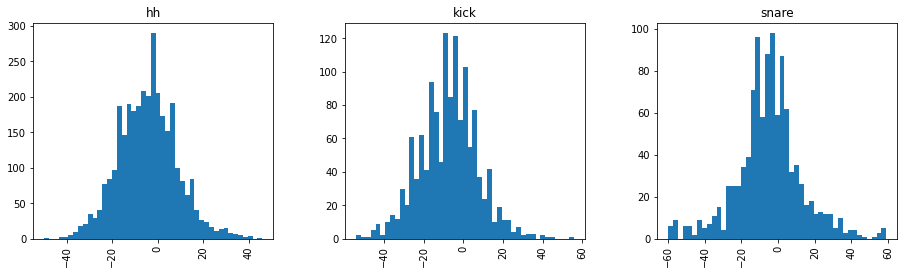

In [27]:
plt.rcParams["figure.figsize"] = (15,4)
# offsets by instrument, all songs..
_ = master_df.beat_offset.hist(by=master_df['note'], bins=45, layout=(1, 3))

Using MIDI ticks...


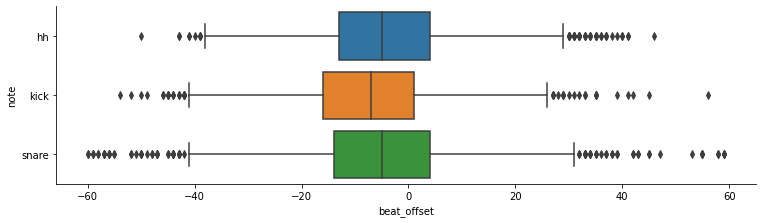

In [28]:
print('Using MIDI ticks...')
#sns.catplot(y="note", y="beat_offset", kind="box", data=master_df)
# PPQN offset boxplots, all data, grouped by instrument.
_ = sns.catplot(y="note", x="beat_offset", kind="box", data=master_df, orient="h", height=3, aspect=3.5/1)

Check qqplot...

In [29]:
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot

plt.rcParams["figure.figsize"] = (8,6)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Using MIDI ticks...


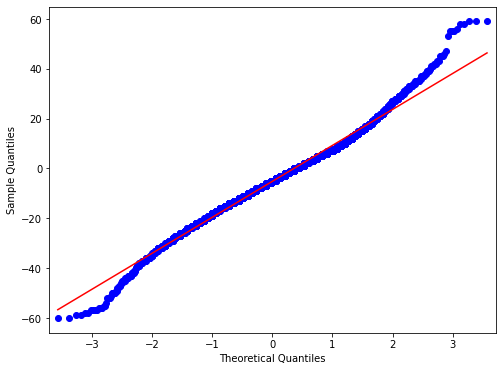

In [30]:
# q-q plot for PPQN
print('Using MIDI ticks...')
_ = qqplot(master_df.beat_offset, line='s')

Statistical test of normality.
* https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/ 

Dealing with non-normal distributions ...
* https://www.statisticshowto.com/probability-and-statistics/non-normal-distributions/

"The tests assume that that the sample was drawn from a Gaussian distribution. Technically this is called the null hypothesis, or H0.""

Really good description of p-values!
* https://www.simplypsychology.org/p-value.html 




"The level of statistical significance is often expressed as a p-value between 0 and 1. The smaller the p-value, the stronger the evidence that you should reject the null hypothesis.

A p-value less than 0.05 (typically ≤ 0.05) is statistically significant. It indicates strong evidence against the null hypothesis, as there is less than a 5% probability the null is correct (and the results are random). Therefore, we reject the null hypothesis, and accept the alternative hypothesis.
However, this does not mean that there is a 95% probability that the research hypothesis is true. The p-value is conditional upon the null hypothesis being true is unrelated to the truth or falsity of the research hypothesis.

A p-value higher than 0.05 (> 0.05) is not statistically significant and indicates strong evidence for the null hypothesis. This means we retain the null hypothesis and reject the alternative hypothesis. You should note that you cannot accept the null hypothesis, we can only reject the null or fail to reject it.
A statistically significant result cannot prove that a research hypothesis is correct (as this implies 100% certainty).

Instead, we may state our results “provide support for” or “give evidence for” our research hypothesis (as there is still a slight probability that the results occurred by chance and the null hypothesis was correct – e.g. less than 5%)."




In [31]:
from scipy import stats
beat_offset_shapiro_test = stats.shapiro(master_df.beat_offset)
s, p = beat_offset_shapiro_test
print('statistic: {}, p-value: {}'.format(s,p))
alpha = 0.05
print('stat: {:f}, p: {:.25f}, alpha:{}, p<alpha: {}\n'.format(s,p, alpha, p<alpha))

statistic: 0.9885942339897156, p-value: 6.19960681167592e-21
stat: 0.988594, p: 0.0000000000000000000061996, alpha:0.05, p<alpha: True



/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


... p-value < .001, reject H0 the data is normal, most likely not.

## Normality tests: velocity

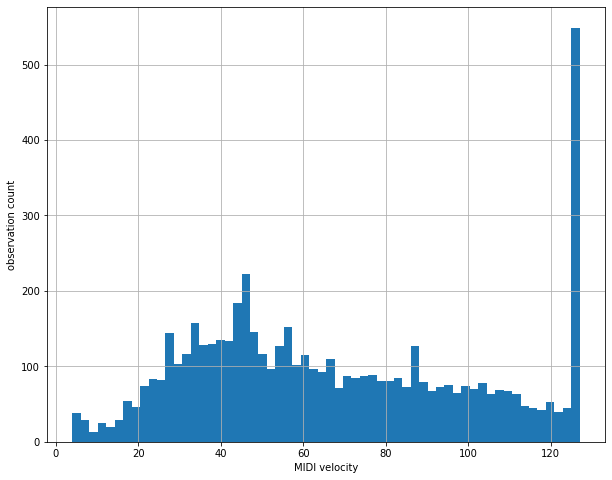

In [32]:
plt.rcParams["figure.figsize"] = (10,8)
_ = plt.ylabel('observation count')
_ = plt.xlabel('MIDI velocity')

# check velocity distributions, MIDI 0-127
_ = master_df.velocity.hist(bins=60)

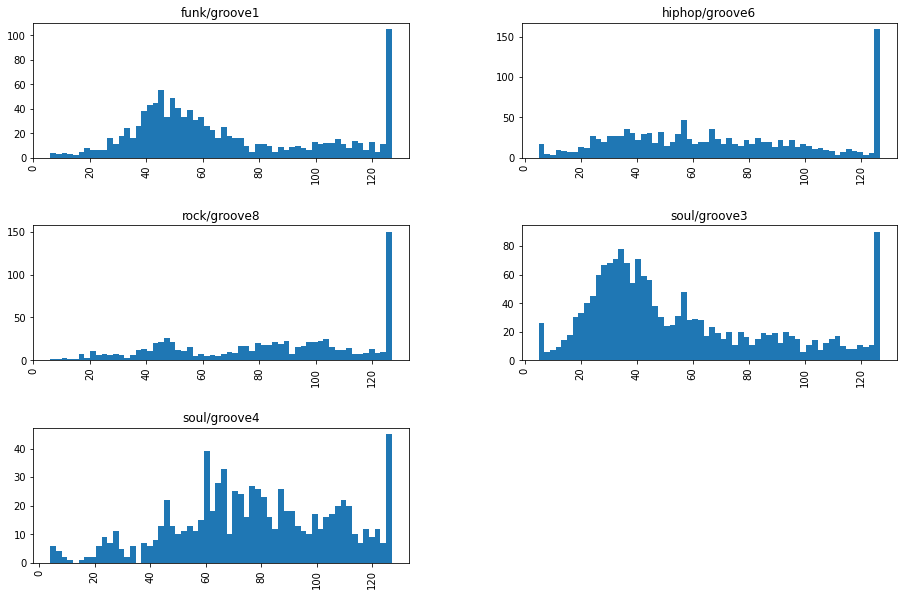

In [33]:
plt.rcParams["figure.figsize"] = (15,10)

# velocity distributions for all recorded songs, grouped by style
_ = master_df.velocity.hist(by=master_df['style'], bins=60)

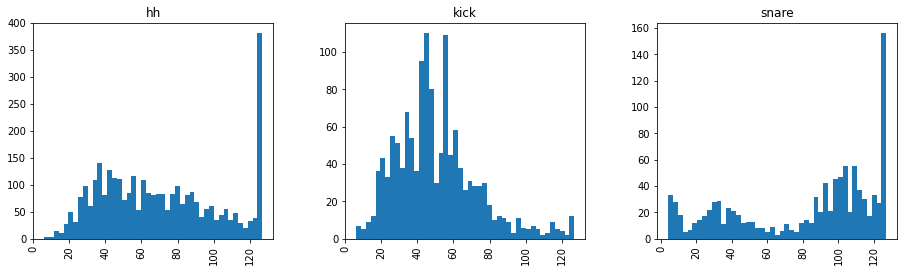

In [34]:
plt.rcParams["figure.figsize"] = (15,4)
# velocity distributions for all recorded songs, grouped by instrument
_ = master_df.velocity.hist(by=master_df['note'], bins=45, layout=(1, 3))

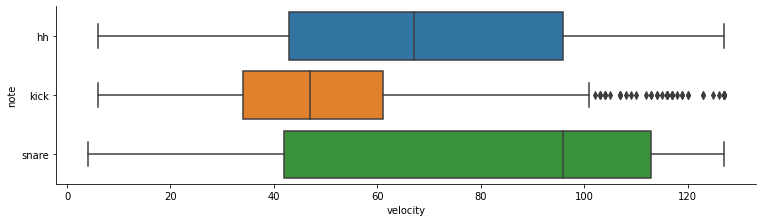

In [35]:
# velocity boxplots, all data, grouped by instrument.
_ = sns.catplot(y="note", x="velocity", kind="box", data=master_df, orient="h", height=3, aspect=3.5/1)
#sns.catplot(x="note", y="velocity", kind="box", data=master_df, height=8, aspect=1/2)
#sns.catplot(x="note", y="velocity", kind="violin", data=master_df, hue='style', height=4, aspect=2.5/1)



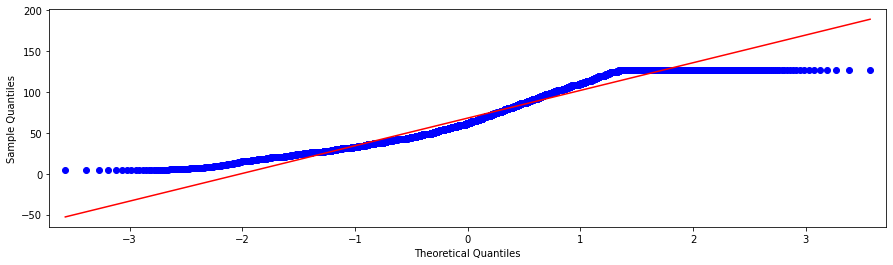

In [36]:
# q-q plot
_ = qqplot(master_df.velocity, line='s')

In [37]:
velocity_shapiro_test = stats.shapiro(master_df.velocity)
s, p = velocity_shapiro_test
print('statistic: {}, p-value: {}'.format(s,p))
alpha = 0.05
print('stat: {:f}, p: {:.25f}, alpha: {}, p<alpha: {}\n'.format(s,p, alpha, p<alpha))

statistic: 0.9465588927268982, p-value: 3.930081673045382e-41
stat: 0.946559, p: 0.0000000000000000000000000, alpha: 0.05, p<alpha: True



/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


... p-value < .001, reject H0 the data is normal, most likely not.


## Check correlations

In [38]:
def plotHeat(corr):
  ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
    )
  
  ax.set_xticklabels(
      ax.get_xticklabels(),
      rotation=45,
      horizontalalignment='right'
  );

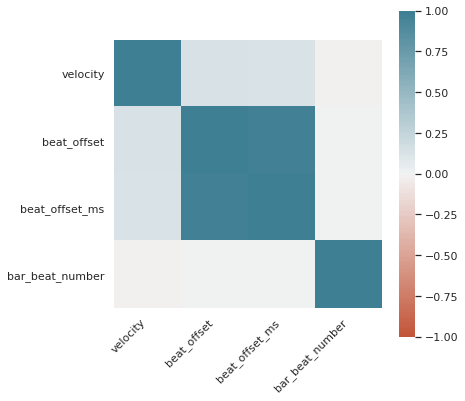

In [39]:
sns.set(rc={'figure.figsize':(6,6)})
plotHeat(master_df.corr())

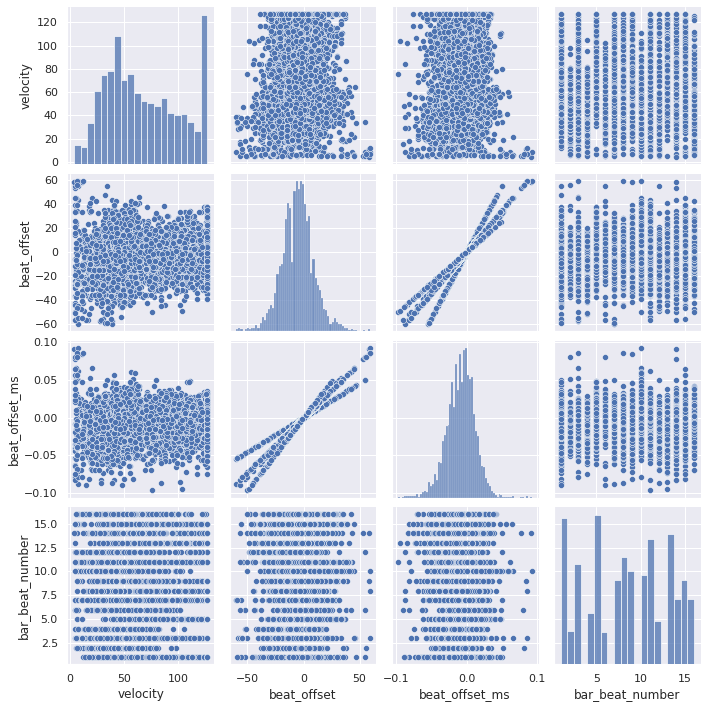

In [40]:
# Basic correlogram
sns.set(rc={'figure.figsize':(15,15)})
sns.pairplot(master_df)
plt.show()


## Across beat positions

Chart settings..
* https://matplotlib.org/tutorials/introductory/customizing.html

In [41]:
master_df.head()

,drummer_ID,note,velocity,beat_offset,beat_offset_ms,bar_beat_number,style
0,drummer1,hh,55,7,0.006341,1,funk/groove1
1,drummer1,kick,64,10,0.009058,1,funk/groove1
2,drummer1,kick,57,-29,-0.026268,3,funk/groove1
3,drummer1,hh,31,-2,-0.001812,3,funk/groove1
4,drummer1,hh,54,-13,-0.011775,5,funk/groove1


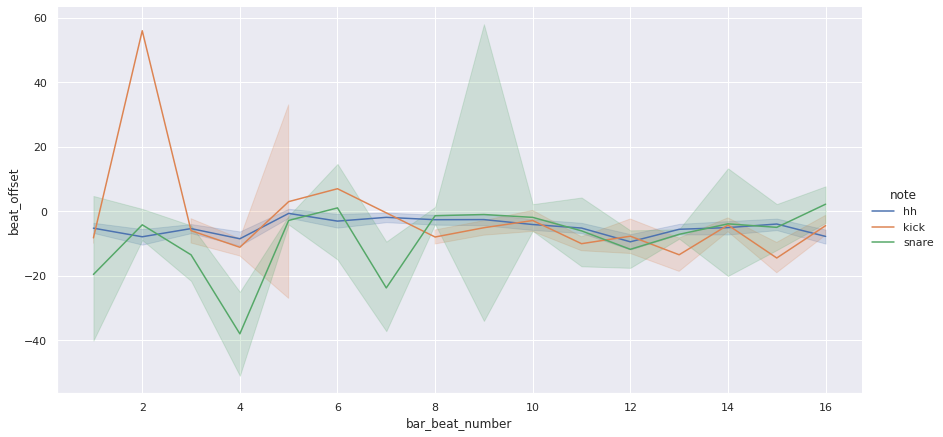

In [42]:
sns.set_theme(style="darkgrid")

sns.relplot(x="bar_beat_number", y="beat_offset", kind="line", data=master_df, height=6, aspect=2, hue="note")

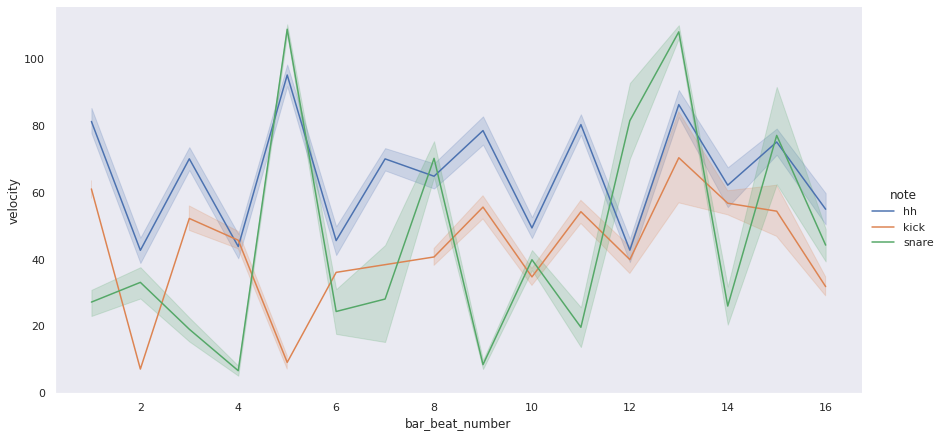

In [43]:
sns.relplot(x="bar_beat_number", y="velocity", kind="line", data=master_df, height=6, aspect=2, hue="note")
plt.grid()

# Stats: per drummer

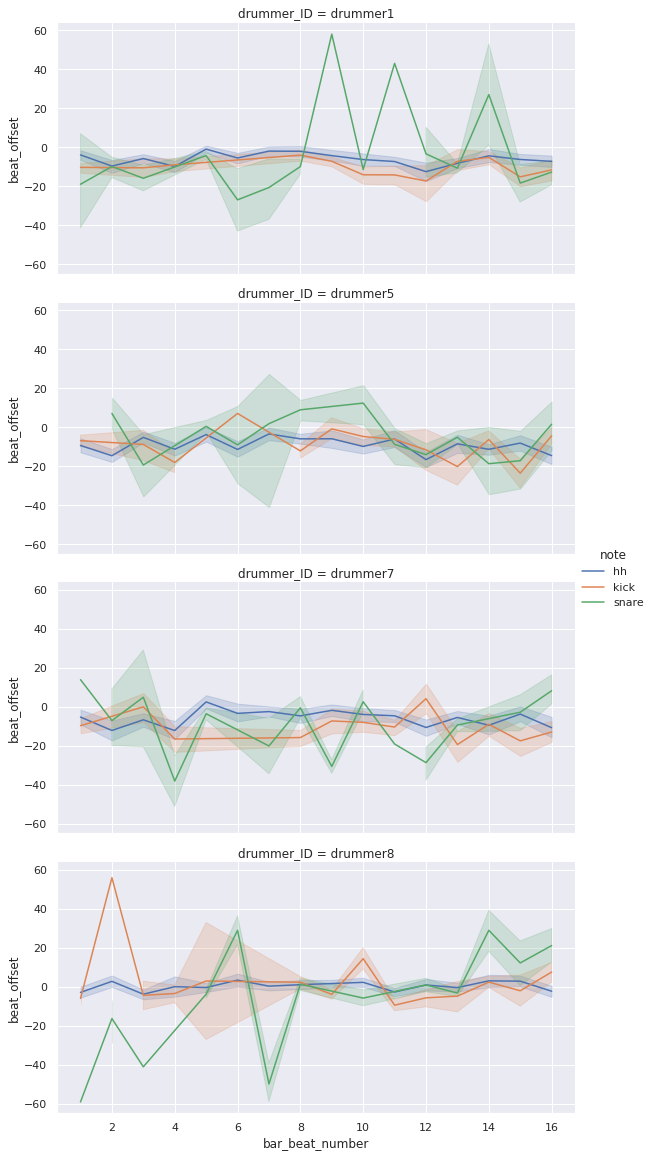

In [44]:
sns.relplot(x="bar_beat_number", y="beat_offset", #ci=None,
            col="drummer_ID", kind="line", col_wrap=1, data=master_df, height=4, aspect=2, hue="note")

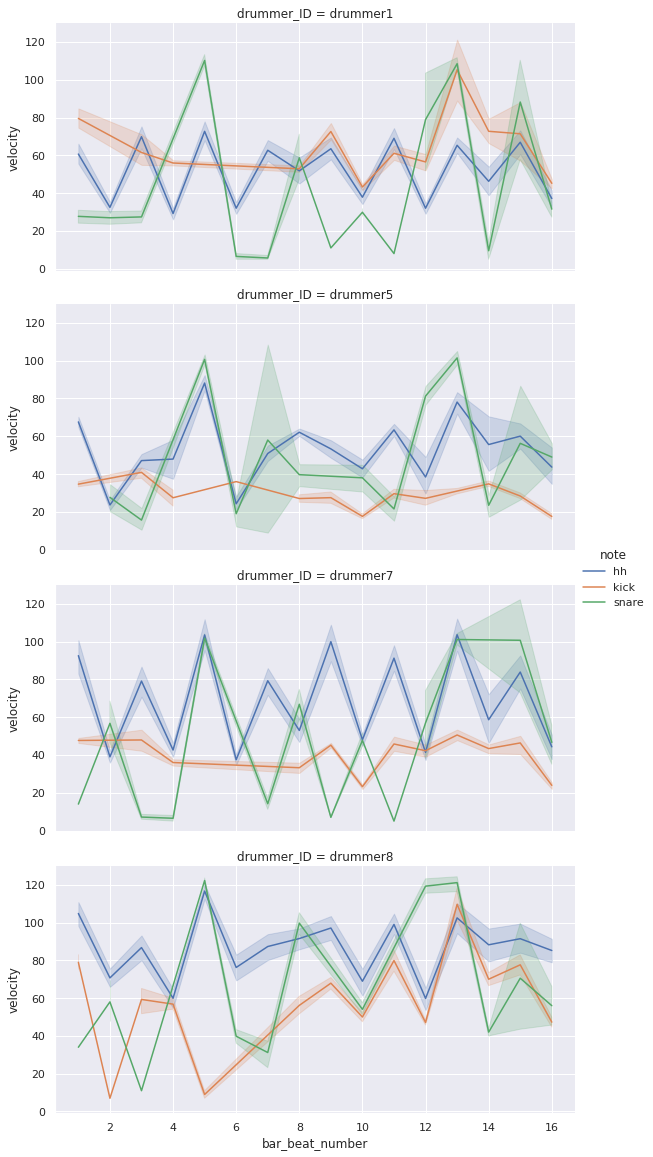

In [45]:
sns.relplot(x="bar_beat_number", y="velocity", #ci=None, 
            col="drummer_ID", kind="line", col_wrap=1, data=master_df, height=4, aspect=2, hue="note")

## Distributions per instrument

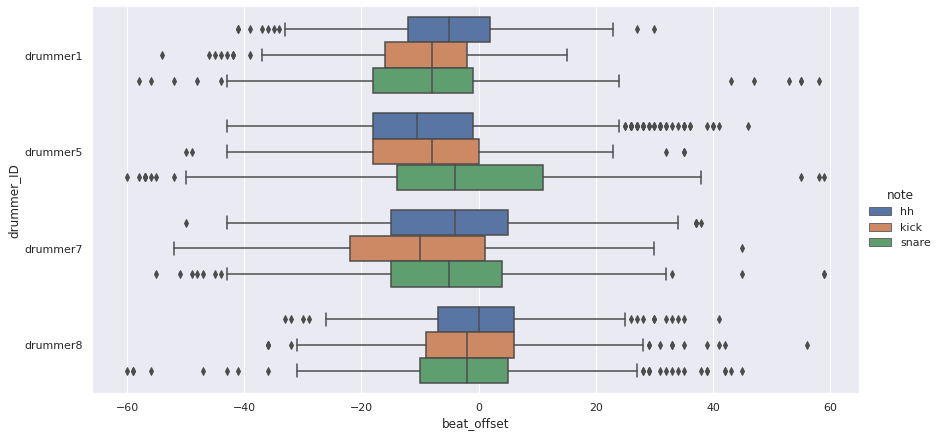

In [66]:
# where does each drummer feel the beat?
_ = sns.catplot(y="drummer_ID", x="beat_offset", kind="box", hue="note", orient="h", height=6, aspect=2,data=master_df)

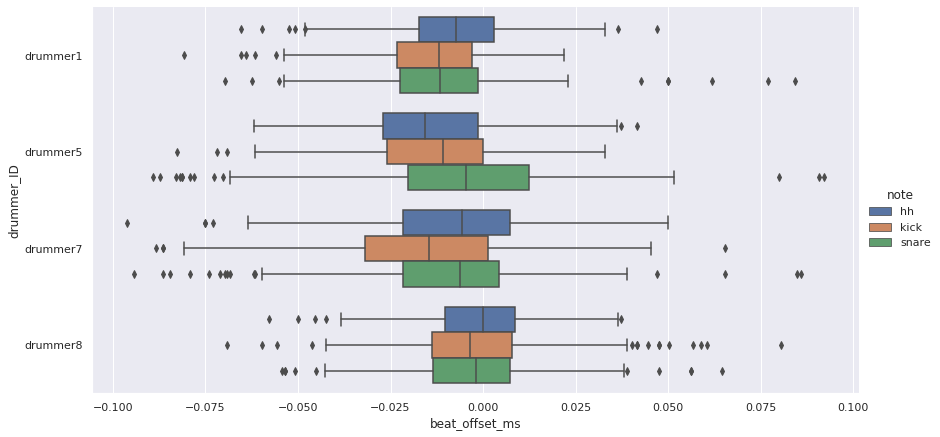

In [67]:
_ = sns.catplot(y="drummer_ID", x="beat_offset_ms", kind="box", hue="note", orient="h", height=6, aspect=2,data=master_df)

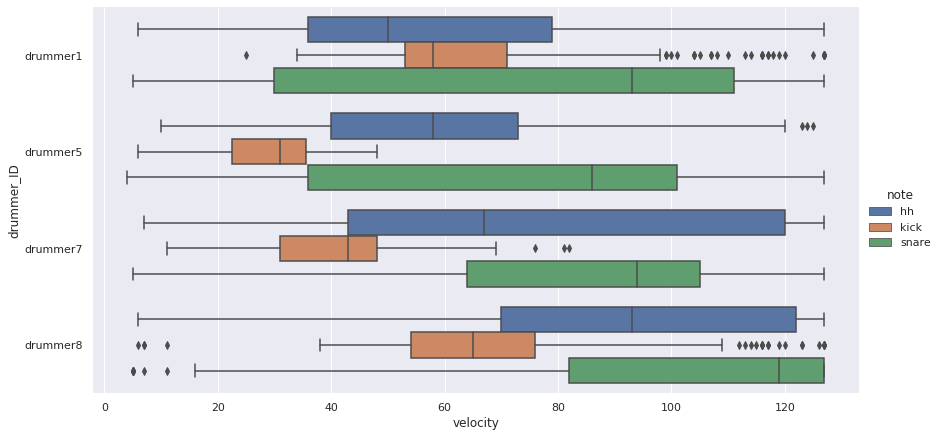

In [68]:
# what is the dynamic range of each drummer?
_ = sns.catplot(y="drummer_ID", x="velocity", kind="box", hue="note", orient="h", height=6, aspect=2, data=master_df)

## Total notes per drummer in the data

In [49]:
print('DataFrame shape: {}\n'.format(master_df.shape))
print('Total notes per drummer...')
master_df.groupby(['drummer_ID'])['drummer_ID'].count() #describe() #['count']


DataFrame shape: (5631, 7)

Total notes per drummer...


drummer_ID
drummer1    1498
drummer5    1336
drummer7    1372
drummer8    1425
Name: drummer_ID, dtype: int64

## Total notes per drummer, per instrument/ hand

In [50]:
print('Total notes per drummer, per instrument, for all songs...')
notes_per_hand = master_df.groupby(['drummer_ID', 'note'])['note'].count().unstack()
notes_per_hand['TOTAL']=notes_per_hand.sum(axis=1)
display(notes_per_hand)


Total notes per drummer, per instrument, for all songs...


note,hh,kick,snare,TOTAL
drummer_ID,,,,
drummer1,872,327,299,1498
drummer5,732,331,273,1336
drummer7,801,330,241,1372
drummer8,830,347,248,1425


## Summary metrics per drummer, per instrument/ hand

In [51]:
# Statistics per drummer, per limb, all data…
master_df.groupby(['drummer_ID', 'note'])[['velocity', 'beat_offset']].describe() #['count']


velocity                                                   \
                    count        mean        std   min   25%    50%    75%   
drummer_ID note                                                              
drummer1   hh       872.0   57.323394  26.063968   6.0  36.0   50.0   79.0   
           kick     327.0   64.914373  20.343040  25.0  53.0   58.0   71.0   
           snare    299.0   74.749164  42.126774   5.0  30.0   93.0  111.0   
drummer5   hh       732.0   58.087432  24.014371  10.0  40.0   58.0   73.0   
           kick     331.0   29.329305   8.853540   6.0  22.5   31.0   35.5   
           snare    273.0   69.139194  39.021709   4.0  36.0   86.0  101.0   
drummer7   hh       801.0   76.121099  37.360327   7.0  43.0   67.0  120.0   
           kick     330.0   40.363636  11.700721  11.0  31.0   43.0   48.0   
           snare    241.0   82.062241  33.188732   5.0  64.0   94.0  105.0   
drummer8   hh       830.0   91.640964  29.025445   6.0  70.0   93.0  122.0   
           kick     347.0   66.979827  20.058502   6.0  54.0   65.0   76.0   
           snare    248.0  101.512097  34.942519   5.0  82.0  119.0  127.0   

                        beat_offset                                          \
                    max       count       mean        std   min   25%   50%   
drummer_ID note                                                               
drummer1   hh     127.0       872.0  -5.413991  10.732396 -41.0 -12.0  -5.0   
           kick   127.0       327.0  -9.883792  12.085532 -54.0 -16.0  -8.0   
           snare  127.0       299.0  -9.150502  15.711560 -58.0 -18.0  -8.0   
drummer5   hh     125.0       732.0  -7.517760  15.343614 -43.0 -18.0 -10.5   
           kick    48.0       331.0  -8.567976  14.183347 -50.0 -18.0  -8.0   
           snare  127.0       273.0  -2.890110  21.524670 -60.0 -14.0  -4.0   
drummer7   hh     127.0       801.0  -4.731586  13.901856 -50.0 -15.0  -4.0   
           kick    82.0       330.0 -10.151515  15.861140 -52.0 -22.0 -10.0   
           snare  127.0       241.0  -5.572614  16.994727 -55.0 -15.0  -5.0   
drummer8   hh     127.0       830.0  -0.037349  10.139785 -33.0  -7.0   0.0   
           kick   127.0       347.0  -1.259366  13.994286 -36.0  -9.0  -2.0   
           snare  127.0       248.0  -1.024194  16.263251 -60.0 -10.0  -2.0   

                              
                   75%   max  
drummer_ID note               
drummer1   hh      2.0  30.0  
           kick   -2.0  15.0  
           snare  -1.0  58.0  
drummer5   hh     -1.0  46.0  
           kick    0.0  35.0  
           snare  11.0  59.0  
drummer7   hh      5.0  38.0  
           kick    1.0  45.0  
           snare   4.0  59.0  
drummer8   hh      6.0  41.0  
           kick    6.0  56.0  
           snare   5.0  45.0

# Stats per song.
Handy techniques in here ...
* https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html

p.s. - IMPORTANT... why are my models so crap at detecting who's who on tune '4_soul-groove4' ?!

In [52]:
print('Total notes per drummer, per instrument, split by song...')
notes_per_style_limb = master_df.groupby(['drummer_ID', 'style', 'note'])['note'].count().unstack()
notes_per_style_limb['TOTAL']=notes_per_style_limb.sum(axis=1)
notes_per_style_limb

Total notes per drummer, per instrument, split by song...


note                        hh  kick  snare  TOTAL
drummer_ID style                                  
drummer1   funk/groove1    126    54     79    259
           hiphop/groove6  222   105     33    360
           rock/groove8    120    56     40    216
           soul/groove3    252    80    115    447
           soul/groove4    152    32     32    216
drummer5   funk/groove1    128    68    101    297
           hiphop/groove6  120    88     28    236
           rock/groove8    119    32     39    190
           soul/groove3    255   111     53    419
           soul/groove4    110    32     52    194
drummer7   funk/groove1    123    56     72    251
           hiphop/groove6  186    99     32    317
           rock/groove8    120    49     44    213
           soul/groove3    256    95     60    411
           soul/groove4    116    31     33    180
drummer8   funk/groove1    127    56     96    279
           hiphop/groove6  170   107     31    308
           rock/groove8    120    56     40    216
           soul/groove3    255    96     49    400
           soul/groove4    158    32     32    222

In [53]:
master_df.groupby(['drummer_ID', 'style'])[['velocity', 'beat_offset']].describe() #['count']

velocity                                             \
                             count        mean        std   min    25%    50%   
drummer_ID style                                                                
drummer1   funk/groove1      259.0   59.023166  23.861508   8.0  44.00   52.0   
           hiphop/groove6    360.0   61.641667  28.539606   5.0  38.00   57.5   
           rock/groove8      216.0   94.268519  23.214112  14.0  81.00   94.0   
           soul/groove3      447.0   41.469799  19.489755   5.0  30.00   37.0   
           soul/groove4      216.0   79.564815  23.528814  11.0  64.00   77.5   
drummer5   funk/groove1      297.0   57.993266  30.944260   6.0  40.00   46.0   
           hiphop/groove6    236.0   53.135593  26.414347   5.0  32.00   51.0   
           rock/groove8      190.0   64.710526  30.126460   6.0  43.00   59.5   
           soul/groove3      419.0   40.000000  22.574385   5.0  24.50   33.0   
           soul/groove4      194.0   63.319588  30.558717   4.0  29.25   67.5   
drummer7   funk/groove1      251.0   83.306773  34.278820  19.0  54.00   77.0   
           hiphop/groove6    317.0   69.842271  41.235282   7.0  38.00   49.0   
           rock/groove8      213.0   67.676056  31.803246   6.0  42.00   58.0   
           soul/groove3      411.0   54.077859  32.831852   5.0  31.00   44.0   
           soul/groove4      180.0   79.883333  26.544845   5.0  56.75   78.5   
drummer8   funk/groove1      279.0   70.684588  31.076272  11.0  47.50   63.0   
           hiphop/groove6    308.0   88.441558  30.142006   5.0  70.00   90.0   
           rock/groove8      216.0  106.754630  26.381459  40.0  83.75  123.5   
           soul/groove3      400.0   87.605000  28.054351  16.0  64.00   86.0   
           soul/groove4      222.0   87.463964  28.374771  23.0  62.25   83.0   

                                         beat_offset                        \
                              75%    max       count       mean        std   
drummer_ID style                                                             
drummer1   funk/groove1     65.50  127.0       259.0  -8.382239  16.705284   
           hiphop/groove6   83.00  127.0       360.0  -3.386111   9.770248   
           rock/groove8    111.25  127.0       216.0  -3.888889   9.281473   
           soul/groove3     49.00  121.0       447.0 -13.089485  11.484286   
           soul/groove4     97.00  127.0       216.0  -2.814815   8.771145   
drummer5   funk/groove1     74.00  127.0       297.0   8.774411  18.573438   
           hiphop/groove6   72.00  120.0       236.0 -13.453390  14.747302   
           rock/groove8     90.00  127.0       190.0 -12.226316   9.763139   
           soul/groove3     55.00  124.0       419.0 -12.317422  12.036705   
           soul/groove4     88.50  127.0       194.0  -5.541237  13.873255   
drummer7   funk/groove1    124.50  127.0       251.0   3.525896  13.872935   
           hiphop/groove6  127.00  127.0       317.0 -15.536278  12.996693   
           rock/groove8     98.00  127.0       213.0 -12.084507  14.857258   
           soul/groove3     69.50  127.0       411.0  -4.416058  13.169797   
           soul/groove4    105.00  127.0       180.0  -0.300000  12.494870   
drummer8   funk/groove1     92.00  127.0       279.0   2.971326  16.883410   
           hiphop/groove6  115.25  127.0       308.0   5.948052  11.630462   
           rock/groove8    127.00  127.0       216.0  -2.398148   8.835910   
           soul/groove3    112.25  127.0       400.0  -4.512500  10.298543   
           soul/groove4    116.75  127.0       222.0  -4.774775   7.198774   

                                                          
                            min    25%   50%   75%   max  
drummer_ID style                                          
drummer1   funk/groove1   -58.0 -17.00  -7.0   1.5  55.0  
           hiphop/groove6 -39.0 -10.00  -3.0   3.0  43.0  
           rock/groove8   -42.0  -9.00  -3.0   2.0  19.0  
           so

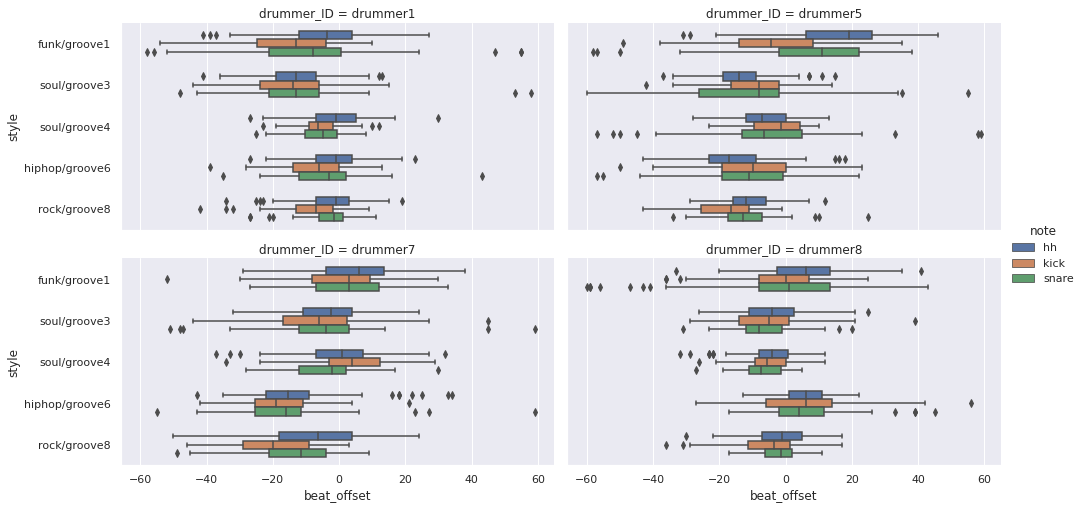

In [54]:
# _= sns.axes_style("darkgrid")
_ = sns.catplot(y="style", x="beat_offset", kind="box", col="drummer_ID", col_wrap=2, hue="note", orient="h", height=3.5, aspect=2,data=master_df, width=0.6)

fyi, using hatching in boxplots ...
* https://stackoverflow.com/questions/42185000/add-hash-pattern-to-a-seaborn-bar-plot
* https://matplotlib.org/examples/pylab_examples/hatch_demo.html


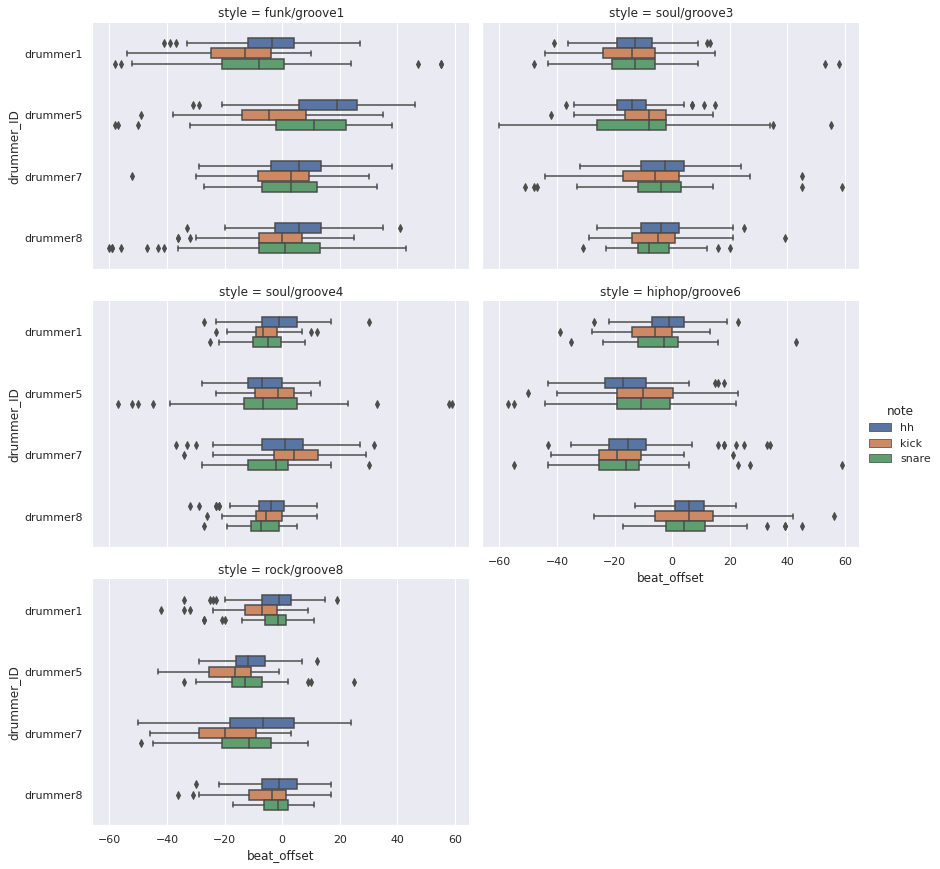

In [55]:

# sns.catplot(y="drummer_ID", x="beat_offset", kind="box", col="style", col_wrap=1, hue="note", orient="h", height=6, aspect=2,data=master_df)

_ = sns.catplot(y="drummer_ID", x="beat_offset", kind="box", col="style", col_wrap=2, hue="note", orient="h", height=4, aspect=1.5, data=master_df, width=0.5)


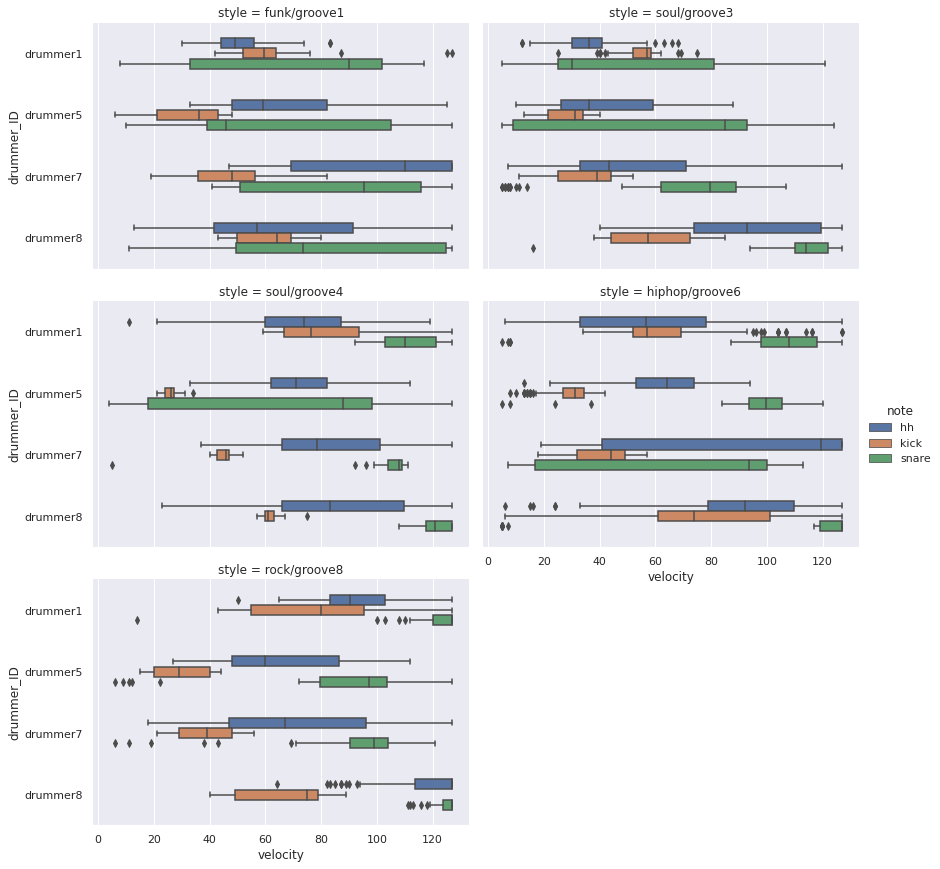

In [56]:
_ = sns.catplot(y="drummer_ID", x="velocity", kind="box", col="style", col_wrap=2, hue="note", orient="h", height=4, aspect=1.5, data=master_df, width=0.5)

# Compare spread of notes offset/ vel for each song across all drummers

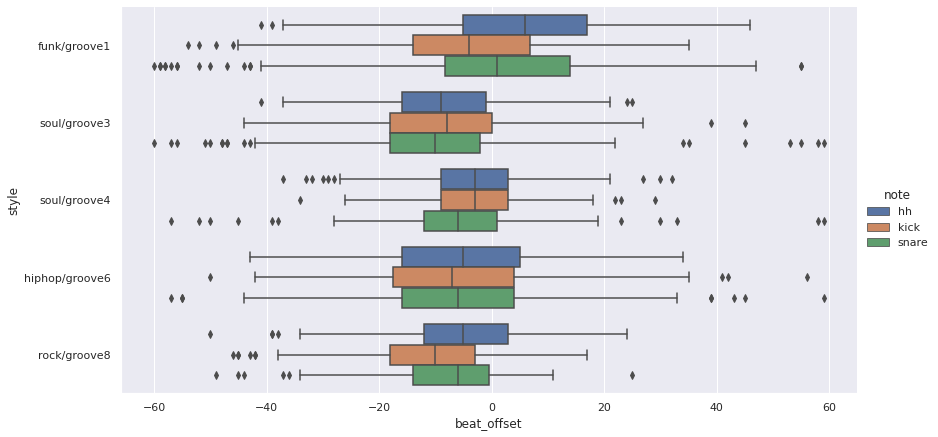

In [57]:
sns.catplot(y="style", x="beat_offset", kind="box",  hue="note", orient="h", height=6, aspect=2,data=master_df)

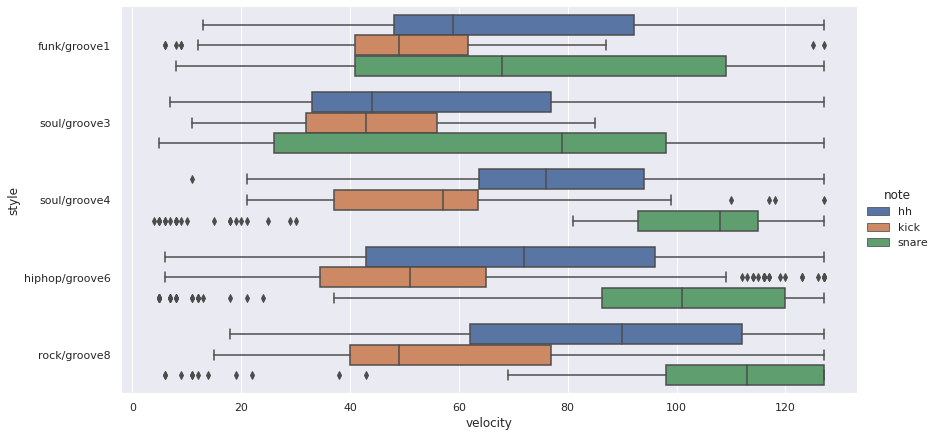

In [58]:
sns.catplot(y="style", x="velocity", kind="box",  hue="note", orient="h", height=6, aspect=2,data=master_df)

# Show beats in a bar format (i.e. bar_beat_number)

In [59]:
master_df[master_df['style'].isin(["funk/groove1"])].head()

,drummer_ID,note,velocity,beat_offset,beat_offset_ms,bar_beat_number,style
0,drummer1,hh,55,7,0.006341,1,funk/groove1
1,drummer1,kick,64,10,0.009058,1,funk/groove1
2,drummer1,kick,57,-29,-0.026268,3,funk/groove1
3,drummer1,hh,31,-2,-0.001812,3,funk/groove1
4,drummer1,hh,54,-13,-0.011775,5,funk/groove1


## Proof data is a bit dodgy compared to how we'd like..
.. this arrangement shows for a single song, strokes by drummers in each beat position, and it's clear that the counts are off many times

In [60]:
bar_view_df = master_df[master_df['style'].isin(["funk/groove1"])].groupby(['drummer_ID', 'note', 'bar_beat_number'])['note'].count().unstack()
bar_view_df.fillna('-')
#display(bar_view_df)

bar_beat_number   1   2   3  4   5  6   7   8   9   10  11  12  13 14  15  16
drummer_ID note                                                              
drummer1   hh     16   -  16  3  16  -  16   -  15   -  12   -  16  -  16   -
           kick   12   -  16  4   -  -   -   -   -   -  15   6   -  1   -   -
           snare   8   5   -  -  16  -   -  16   -  15   -   2   8  -   8   1
drummer5   hh     16   -  16  -  16  -  16   -  16   -  16   -  16  -  16   -
           kick   13   -  16  6   -  -   -   -   3   -  16  14   -  -   -   -
           snare   -  11   4  -  14  2   2  14   -  16   7   -  11  2   5  13
drummer7   hh     16   -  16  -  16  -  16   -  16   -  12   -  15  -  16   -
           kick   12   -  16  4   -  -   -   -   -   -  16   8   -  -   -   -
           snare   -   4   -  -  16  -   -  16   -  12   -   -   8  -   8   8
drummer8   hh     16   -  16  -  16  -  16   -  16   -  16   -  16  -  15   -
           kick   13   -  16  3   -  -   -   -   -   -  16   8   -  -   -   -
           snare   1   4   1  -  16  6   4  16   -  16   -   -   8  4   9  11

In [61]:
# do the above, for all styles at once...
master_df_style = master_df.copy()
master_df_style.set_index('style', append=True, inplace=True)
bar_view_df = master_df_style.groupby(['style','drummer_ID', 'note', 'bar_beat_number'])['note'].count().unstack()
bar_view_df = bar_view_df.fillna('-')
display(bar_view_df)

bar_beat_number                  1   2   3   4   5   6   7   8   9   10  11  \
style          drummer_ID note                                                
funk/groove1   drummer1   hh     16   -  16   3  16   -  16   -  15   -  12   
                          kick   12   -  16   4   -   -   -   -   -   -  15   
                          snare   8   5   -   -  16   -   -  16   -  15   -   
               drummer5   hh     16   -  16   -  16   -  16   -  16   -  16   
                          kick   13   -  16   6   -   -   -   -   3   -  16   
                          snare   -  11   4   -  14   2   2  14   -  16   7   
               drummer7   hh     16   -  16   -  16   -  16   -  16   -  12   
                          kick   12   -  16   4   -   -   -   -   -   -  16   
                          snare   -   4   -   -  16   -   -  16   -  12   -   
               drummer8   hh     16   -  16   -  16   -  16   -  16   -  16   
                          kick   13   -  16   3   -   -   -   -   -   -  16   
                          snare   1   4   1   -  16   6   4  16   -  16   -   
hiphop/groove6 drummer1   hh     12  12  12  12  16  16  16  16  16  16  16   
                          kick   16   -   -  11   -   -   -  16   -  16  16   
                          snare   -   -   -   -  16   1   -   -   -   -   1   
               drummer5   hh     16   -  16   -  16   -  16   -  16   -  13   
                          kick   13   -   2   -   -   1   -  15   3   7  16   
                          snare   -   -   1   -  16   2   -   -   -   -   1   
               drummer7   hh      8   8   8   8  16  16  16  16  16  15  15   
                          kick   16   -   -   4   -   -   -  16   -  16  16   
                          snare   -   -   1   -  15   -   3   3   2   -   -   
               drummer8   hh      8   8   8   8  16  16  16  16  16  10   8   
                          kick   16   1   1   8   2   -   -  15   -  16  16   
                          snare   -   -   -   -  16   -   -   -   -   -   -   
rock/groove8   drummer1   hh     16   -  16   -  16   -  16   -  16   -  16   
                          kick   16   -   -   -   -   -   -  16  16   -   -   
                          snare   -   -   -   -  15   -   -   -   -   -   -   
               drummer5   hh     16   -  16   -  16   -  16   -  16   -  16   
                          kick   11   -   -   -   -   -   -  16   -   -   -   
                          snare   -   -   2   -  12   1   -   -   -   -   -   
               drummer7   hh     16   -  16   -  16   -  16   -  16   -  16   
                          kick   15   -   -   -   -   -   -  16  15   -   -   
                          snare   -   -   -   -  16   -   2   -   -   -   -   
               drummer8   hh     16   -  16   -  16   -  16   -  16   -  16   
                          kick   16   -   -   -   -   -   -  16  16   -   -   
                          snare   -   -   -   -  16   -   -   -   -   -   -   
soul/groove3   drummer1   hh     16  16  16  16  16  14  16  16  16  16  16   
                          kick   17   -   -  16   -   -   -   -   -  15  16   
                          snare   2  14  15   -  15   1   3  16   1  14   -   
               drummer5   hh     16  16  16  16  16  15  16  16  16  16  16   
                          kick   16   -   -  16   -   -   -  16   -  16  15   
                          snare   -   3   1   -  16   2   1   1   -   -   1   
               drummer7   hh     16  16  16  16  16  16  16  16  16  16  16   
                          kick   16   -   -  15   -   -   -   -   -  16  16   
                          snare   1   -   6   2  16   -   -  16   -   -   -   
               drummer8   hh     16  16  16  15  16  16  16  16  16  16  16   
                          kick   16   -   -  16   -   -   -   -   -  16  16   
                          snare   -   -   -   -  16   -   1  16   -   -   -   
soul/groove4   drummer1   hh     16   -  16   -  1

Need to copy/ paste into a report, the above is too much, need to break it down into a little table/ df per style, can then be easily broken up to include in a report...

In [62]:
bar_view_df.index.get_level_values(0).unique()

Index(['funk/groove1', 'hiphop/groove6', 'rock/groove8', 'soul/groove3',
       'soul/groove4'],
      dtype='object', name='style')

In [63]:
for i in bar_view_df.index.get_level_values(0).unique():
  print('\n\n Beats per drummer, per limb, at each beat position, for style: {}'.format(i))
  display(bar_view_df.xs(i))



 Beats per drummer, per limb, at each beat position, for style: funk/groove1


bar_beat_number   1   2   3  4   5  6   7   8   9   10  11  12  13 14  15  16
drummer_ID note                                                              
drummer1   hh     16   -  16  3  16  -  16   -  15   -  12   -  16  -  16   -
           kick   12   -  16  4   -  -   -   -   -   -  15   6   -  1   -   -
           snare   8   5   -  -  16  -   -  16   -  15   -   2   8  -   8   1
drummer5   hh     16   -  16  -  16  -  16   -  16   -  16   -  16  -  16   -
           kick   13   -  16  6   -  -   -   -   3   -  16  14   -  -   -   -
           snare   -  11   4  -  14  2   2  14   -  16   7   -  11  2   5  13
drummer7   hh     16   -  16  -  16  -  16   -  16   -  12   -  15  -  16   -
           kick   12   -  16  4   -  -   -   -   -   -  16   8   -  -   -   -
           snare   -   4   -  -  16  -   -  16   -  12   -   -   8  -   8   8
drummer8   hh     16   -  16  -  16  -  16   -  16   -  16   -  16  -  15   -
           kick   13   -  16  3   -  -   -   -   -   -  16   8   -  -   -   -
           snare   1   4   1  -  16  6   4  16   -  16   -   -   8  4   9  11



 Beats per drummer, per limb, at each beat position, for style: hiphop/groove6


bar_beat_number   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
drummer_ID note                                                                
drummer1   hh     12  12  12  12  16  16  16  16  16  16  16  13  14  12  12   
           kick   16   -   -  11   -   -   -  16   -  16  16   -   4  10   5   
           snare   -   -   -   -  16   1   -   -   -   -   1   2  13   -   -   
drummer5   hh     16   -  16   -  16   -  16   -  16   -  13   -  13   -  13   
           kick   13   -   2   -   -   1   -  15   3   7  16   -   8   8   8   
           snare   -   -   1   -  16   2   -   -   -   -   1   -   8   -   -   
drummer7   hh      8   8   8   8  16  16  16  16  16  15  15  10  10   8   8   
           kick   16   -   -   4   -   -   -  16   -  16  16   -   7   8   8   
           snare   -   -   1   -  15   -   3   3   2   -   -   -   7   -   1   
drummer8   hh      8   8   8   8  16  16  16  16  16  10   8   8   8   8   8   
           kick   16   1   1   8   2   -   -  15   -  16  16   -   8   8   8   
           snare   -   -   -   -  16   -   -   -   -   -   -   -   9   -   6   

bar_beat_number   16  
drummer_ID note       
drummer1   hh     11  
           kick   11  
           snare   -  
drummer5   hh      1  
           kick    7  
           snare   -  
drummer7   hh      8  
           kick    8  
           snare   -  
drummer8   hh      8  
           kick    8  
           snare   -



 Beats per drummer, per limb, at each beat position, for style: rock/groove8


bar_beat_number   1  2   3  4   5  6   7   8   9  10  11 12  13 14 15 16
drummer_ID note                                                         
drummer1   hh     16  -  16  -  16  -  16   -  16  -  16  -   8  8  8  -
           kick   16  -   -  -   -  -   -  16  16  -   -  -   -  8  -  -
           snare   -  -   -  -  15  -   -   -   -  -   -  8  16  1  -  -
drummer5   hh     16  -  16  -  16  -  16   -  16  -  16  -   8  7  8  -
           kick   11  -   -  -   -  -   -  16   -  -   -  -   -  5  -  -
           snare   -  -   2  -  12  1   -   -   -  -   -  8  14  2  -  -
drummer7   hh     16  -  16  -  16  -  16   -  16  -  16  -   8  8  8  -
           kick   15  -   -  -   -  -   -  16  15  -   -  -   -  2  -  1
           snare   -  -   -  -  16  -   2   -   -  -   -  8  16  -  1  1
drummer8   hh     16  -  16  -  16  -  16   -  16  -  16  -   8  8  8  -
           kick   16  -   -  -   -  -   -  16  16  -   -  -   -  8  -  -
           snare   -  -   -  -  16  -   -   -   -  -   -  8  16  -  -  -



 Beats per drummer, per limb, at each beat position, for style: soul/groove3


bar_beat_number   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  \
drummer_ID note                                                                
drummer1   hh     16  16  16  16  16  14  16  16  16  16  16  15  15  16  16   
           kick   17   -   -  16   -   -   -   -   -  15  16   -   -  16   -   
           snare   2  14  15   -  15   1   3  16   1  14   -   -  15   1   2   
drummer5   hh     16  16  16  16  16  15  16  16  16  16  16  16  16  16  16   
           kick   16   -   -  16   -   -   -  16   -  16  15   -   -  16   -   
           snare   -   3   1   -  16   2   1   1   -   -   1   -  15   7   6   
drummer7   hh     16  16  16  16  16  16  16  16  16  16  16  16  16  16  16   
           kick   16   -   -  15   -   -   -   -   -  16  16   -   -  16   -   
           snare   1   -   6   2  16   -   -  16   -   -   -   3  16   -   -   
drummer8   hh     16  16  16  15  16  16  16  16  16  16  16  16  16  16  16   
           kick   16   -   -  16   -   -   -   -   -  16  16   -   -  16   -   
           snare   -   -   -   -  16   -   1  16   -   -   -   -  16   -   -   

bar_beat_number   16  
drummer_ID note       
drummer1   hh     16  
           kick    -  
           snare  16  
drummer5   hh     16  
           kick   16  
           snare   -  
drummer7   hh     16  
           kick   16  
           snare   -  
drummer8   hh     16  
           kick   16  
           snare   -



 Beats per drummer, per limb, at each beat position, for style: soul/groove4


bar_beat_number   1  2   3  4   5  6   7   8   9   10  11 12  13 14  15  16
drummer_ID note                                                            
drummer1   hh     16  -  16  -  16  -  16  16   -  16  16  -  16  -  16   8
           kick   16  -   -  -   -  -   -   -  16   -   -  -   -  -   -   -
           snare   -  -   -  -  16  -   -   -   -   -   -  -  16  -   -   -
drummer5   hh      -  -  16  9   -  -  16  16   -  13  16  3   -  -  16   5
           kick   16  -   -  -   -  -   -   -  16   -   -  -   -  -   -   -
           snare   -  1   3  -  16  4   1   -   -   4   4  -  16  2   1   -
drummer7   hh     12  -  16  -   -  -  16  16   -  16  16  -   -  -  16   8
           kick   15  -   -  -   -  -   -   -  16   -   -  -   -  -   -   -
           snare   -  -   -  -  16  -   -   -   -   -   1  -  16  -   -   -
drummer8   hh     15  -  16  -  16  -  16  16   -  15  16  -  16  -  16  16
           kick   16  -   -  -   -  -   -   -  16   -   -  -   -  -   -   -
           snare   -  -   -  -  16  -   -   -   -   -   -  -  16  -   -   -

# Pandas Profiling Report

See...
* https://towardsdatascience.com/exploratory-data-analysis-with-pandas-profiling-de3aae2ddff3

In [64]:
#!pip install  --upgrade pandas-profiling
#from pandas_profiling import ProfileReport
#prof = ProfileReport(master_df)


In [65]:
#prof.to_notebook_iframe()